In [1]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
import monai
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (6, 6)

print_config()

d:\repos\tdt17_mini_project\venv\lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: d:\repos\tdt17_mini_project\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For d

image data shape: torch.Size([1, 512, 512, 75])
meta data: dict_keys(['sizeof_hdr', 'extents', 'session_error', 'dim_info', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'qform_code', 'sform_code', affine, original_affine, 'as_closest_canonical', spatial_shape, space, original_channel_dim, 'filename_or_obj'])


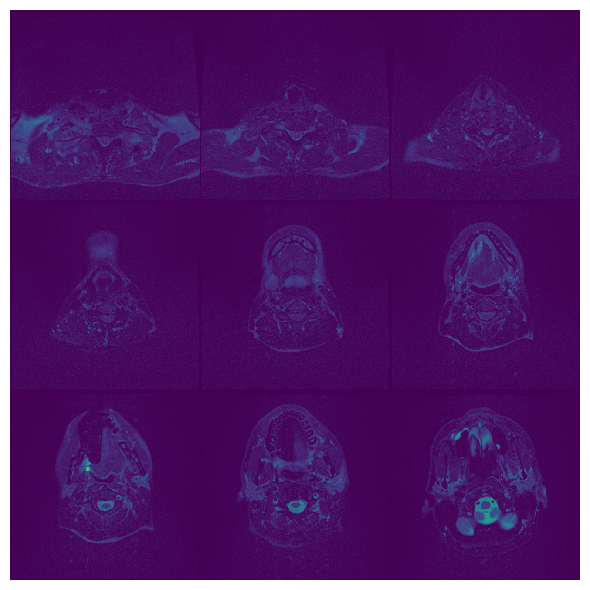

In [2]:
filename = "data/test/29/preRT/29_preRT_T2.nii.gz"
filename_mask = "data/test/29/preRT/29_preRT_mask.nii.gz"

data = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename)
mask = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename_mask)
print(f"image data shape: {data.shape}")
print(f"meta data: {data.meta.keys()}")
mask = mask > 0

masked_data = data + mask*255

monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(masked_data), every_n=9, figsize= (6, 6))
plt.show()


In [3]:
data.meta

{'sizeof_hdr': array(348),
 'extents': array(0),
 'session_error': array(0, dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(16, dtype=int16),
 'bitpix': array(32, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(2, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'slice_duration': array(0., dtype=float32),
 'toffset': array(0., dtype=float32),
 'glmax': array(0),
 'glmin': array(0),
 'qform_code': array(1, dtype=int16),
 'sform_code': array(1, dtype=int16),
 affine: tensor([[  -0.5000,    0.0000,    0.0000,  122.0678],
         [   0.0000,   -0.5000

In [ ]:
from data import create_dataset_dicts
from monai.data import Dataset
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    RandCropByPosNegLabeld,
    RandRotate90d,
    Compose, 
    Resized, 
    Spacingd,
    ToTensord,
    SpatialPadd,
    ToDeviced,
    SelectItemsd,
    NormalizeIntensityd
)


device = "cuda"
data_dicts = create_dataset_dicts("data/train")
train_transforms = Compose(
    [      
        # Load data
        LoadImaged(keys=["image", "mask"]),
        SelectItemsd(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),

        # Normalization and resizing
        NormalizeIntensityd(keys="image"),
        # Resized(keys=["image", "mask"], spatial_size=(256, 256, 80), mode=("bilinear", "nearest")),
        # RandRotate90d(keys=["image", "mask"], prob=0.5, spatial_axes=(0, 1)),
        # ToTensord(keys=["image", "mask"]),
        # ToDeviced(keys=["image", "mask"], device=device),
    ]
)
dataset = Dataset(data_dicts, train_transforms)
dataset[0]['image'].shape

torch.Size([1, 512, 512, 82])

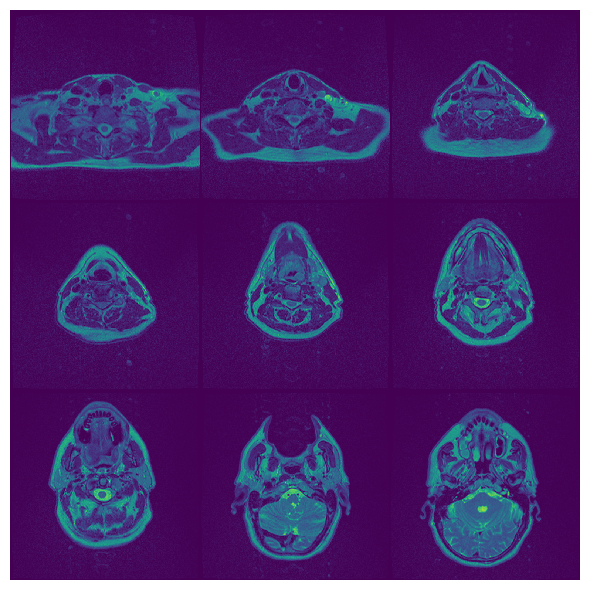

In [57]:
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(dataset[0]['image']), every_n=10, figsize= (6, 6))
plt.show()

In [5]:
shape_tensor = torch.zeros(130, 4)
for i, data in enumerate(tqdm(dataset)):
    shape_tensor[i] = torch.tensor(data['mask'].shape)

max_d = torch.zeros(4)
min_d = torch.zeros(4)
for d in range(shape_tensor.shape[1]):
    min_d[d] = shape_tensor[:,d].min()
    max_d[d] = shape_tensor[:,d].max()
    print(d, shape_tensor[:,d].shape)
min_d, max_d

100%|██████████| 130/130 [01:05<00:00,  1.97it/s]

0 torch.Size([130])
1 torch.Size([130])
2 torch.Size([130])
3 torch.Size([130])


(tensor([  1., 512., 480.,  57.]), tensor([  1., 640., 640., 162.]))

In [6]:
avg_mask = torch.zeros_like(dataset[0]['mask'])
for data in tqdm(dataset):
    avg_mask += data['mask']
avg_mask /= len(dataset)

  1%|          | 1/130 [00:00<02:02,  1.06it/s]


RuntimeError: The size of tensor a (82) must match the size of tensor b (74) at non-singleton dimension 3

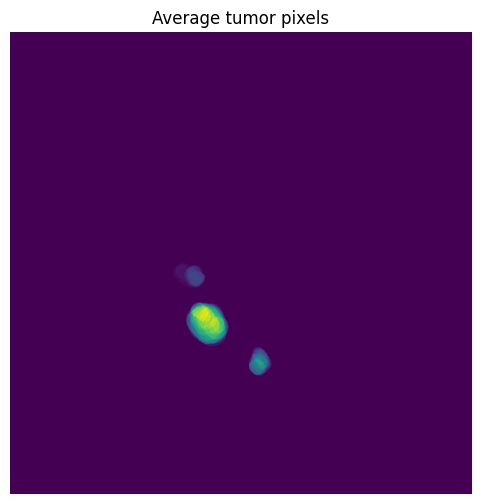

In [7]:
plt.imshow(avg_mask.cpu().mean(3).permute(1,2,0))
plt.axis('off')
plt.title("Average tumor pixels");

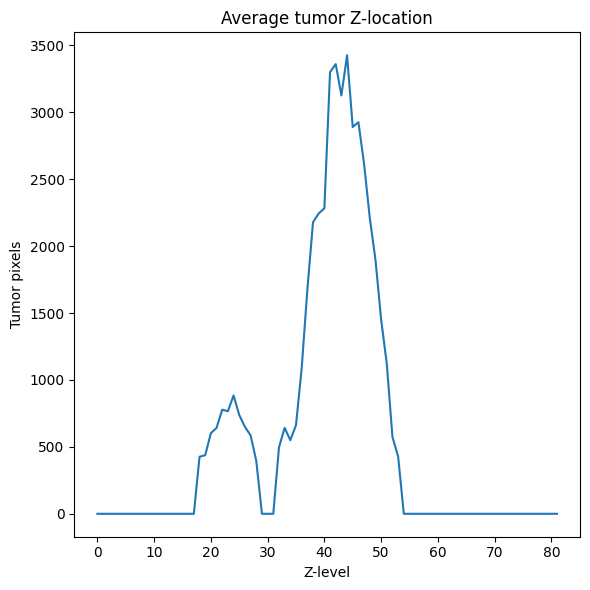

In [58]:
plt.plot(torch.tensor([t.sum() for t in avg_mask[0].permute(2,0,1)]))
plt.xlabel("Z-level")
plt.ylabel("Tumor pixels")
plt.title("Average tumor Z-location")
plt.tight_layout();

In [ ]:
# Tumor percentage
total_pixels = torch.tensor(dataset[0]['mask'].shape).prod()
total_tumor = 0
total_non_tumor = 0
for data in tqdm(dataset):
    total_tumor += data['mask'].sum() / total_pixels
total_tumor /= len(dataset)
total_tumor

100%|██████████| 130/130 [01:15<00:00,  1.72it/s]


In [51]:
max_= 0
min_ = 1000
for data in tqdm(dataset):
    curr = data['image'].max()
    max_ = max_ if max_>=curr else curr
    min_ = min_ if min_<=curr else min_
min_, max_

100%|██████████| 130/130 [01:13<00:00,  1.77it/s]


(metatensor(25.4689), 1000)

In [ ]:
# Calculate intensity distribution
bincounts = torch.zeros(130, 256)
for i, data in enumerate(tqdm(dataset)):
    intensity_values = data['image'].flatten().divide(max_).multiply(255).round().int()
    bincount = torch.bincount(intensity_values, minlength=256)
    bincounts[i, :len(bincount)] = bincount

  0%|          | 0/130 [00:00<?, ?it/s]


RuntimeError: bincount only supports 1-d non-negative integral inputs.

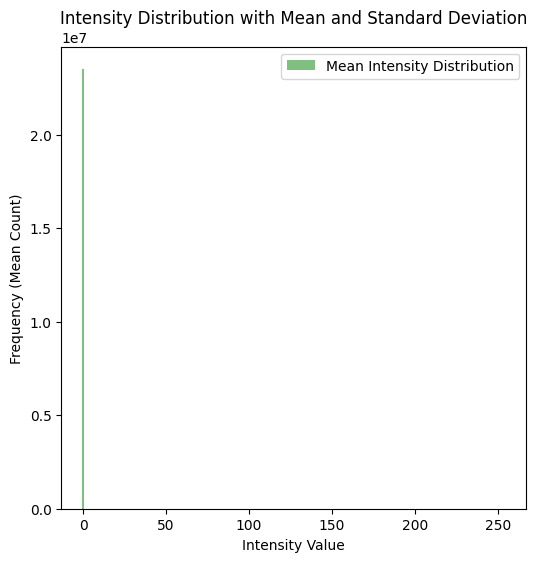

In [44]:
x_extent = 255
mean = bincounts.mean(0)[:x_extent]
std = bincounts.std(0)[:x_extent]

plt.figure(figsize=(6, 6))
plt.bar(range(x_extent), mean, alpha=0.5, label='Mean Intensity Distribution', color='green')
# plt.fill_between(range(x_extent), mean - std, mean + std, color='lightblue', alpha=0.5, label='Standard Deviation')
# plt.yscale('symlog')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency (Mean Count)')
plt.title('Intensity Distribution with Mean and Standard Deviation')
plt.legend()
plt.show()

<Figure size 600x600 with 0 Axes>

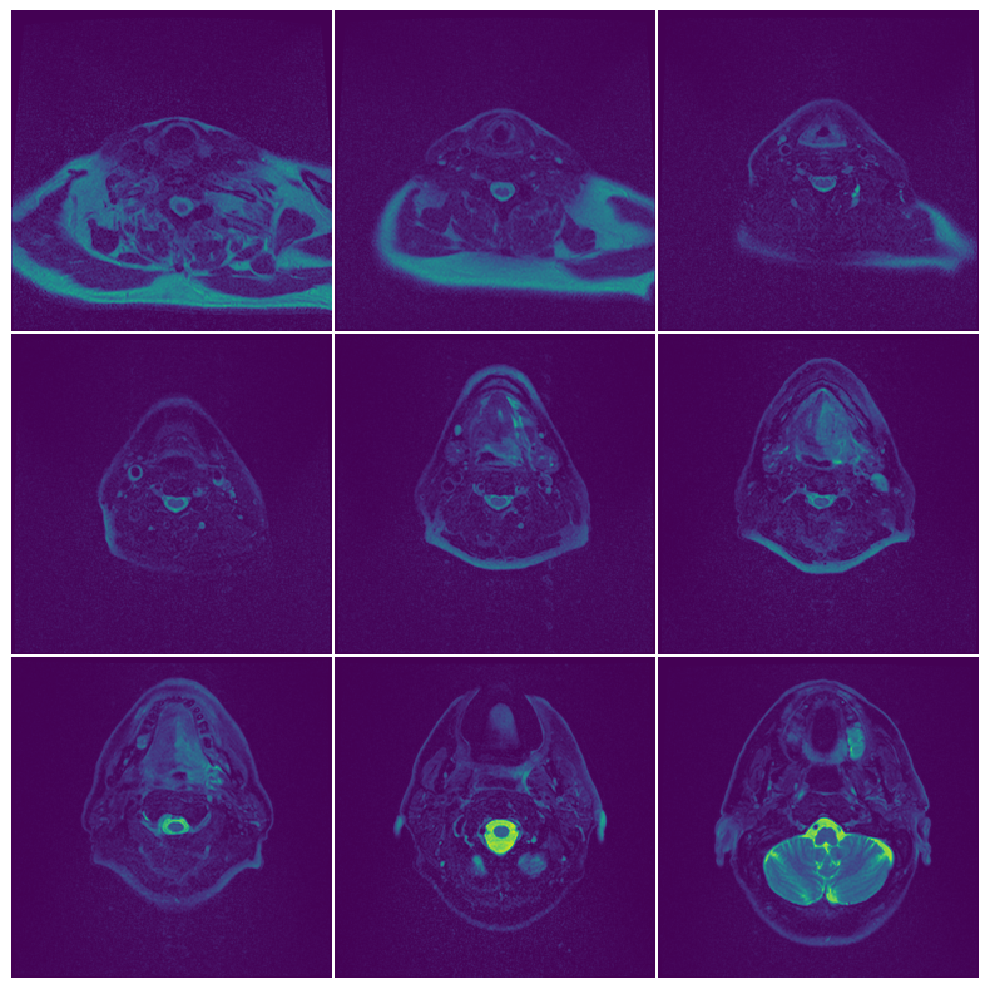

In [ ]:
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(dataset[0]['image']), every_n=9, figsize= (6, 6))
plt.show()

In [ ]:
for item in dataset:
    print(item['image'].shape)

torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])
torch.Size([1, 256, 256, 80])


In [ ]:
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 256, 256, 60),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)

In [ ]:
from monai.data import DataLoader
from tqdm import tqdm
from monai.data import create_test_image_3d, list_data_collate, pad_list_data_collate

loader = DataLoader(dataset, batch_size=1)
sample = next(iter(loader))['image']
sample.shape

torch.Size([1, 1, 256, 256, 80])

In [ ]:
# Training loop
import monai.optimizers

epochs = 1
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
loss_function = monai.losses.DiceLoss(sigmoid=True)

for e in tqdm(range(epochs), position=0, desc="Epoch", disable=True):
    model.train()
    for batch in tqdm(loader, position=1, desc="Training step"):
        inputs, labels = batch['image'], batch['mask']
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_function(preds, labels)
        loss.backward()
        optimizer.step()


Training step: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


In [ ]:
pred = model(sample)
pred.shape

torch.Size([1, 1, 256, 256, 80])

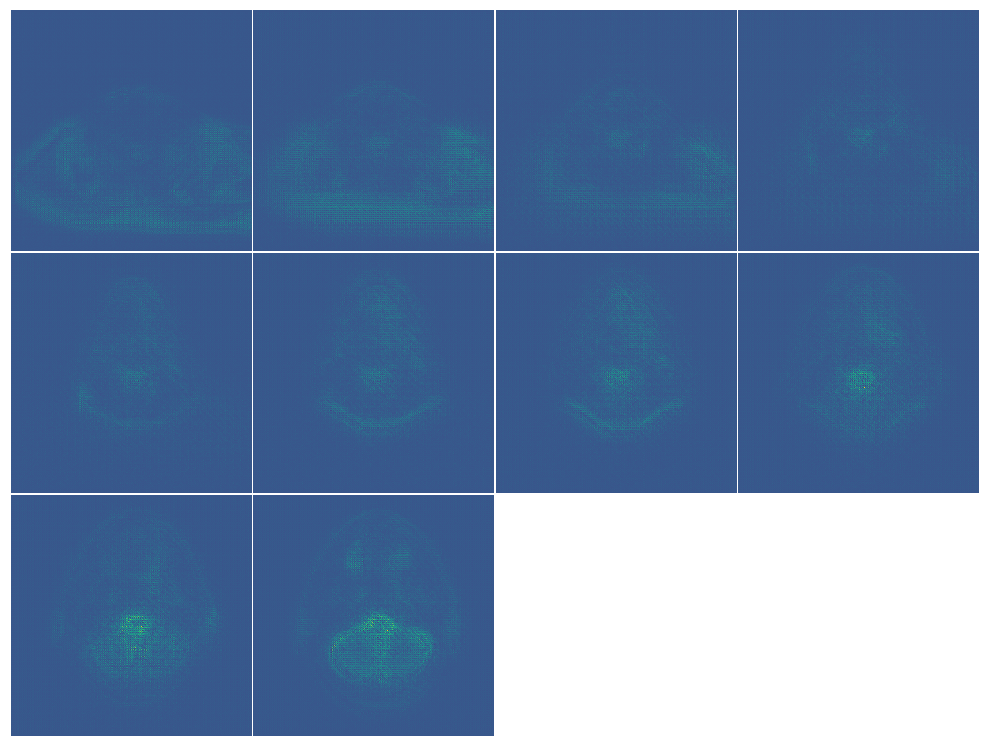

In [ ]:
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(pred[0]), every_n=8)
plt.show()